In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

class LinearRegression:
  def __init__(self, learning_rate, iterations, gradient_descent_type, regularization, lamda):
    self.learning_rate = learning_rate
    self.iterations = iterations
    self.gradient_descent_type = gradient_descent_type
    self.regularization = regularization
    self.lamda = lamda

  def fit(self, X, y):
    self.X = X
    self.y = y
    self.W = np.zeros(X.shape[1])
    self.b = 0
    self.m = X.shape[0]

    for i in range(self.iterations):
      self.adjust()

#adjusts weights according to the selected descent and regularization method
  def adjust(self):
    dWt = np.zeros(self.X.shape[1])
    dbt = 0

    if(self.gradient_descent_type == 'vanilla'):
      vgd = vanilla_gradient_descent()
      vgd.fit(self.X,self.y,self.W,self.b)
      dW1, db1 = vgd.gradients()

    if(self.gradient_descent_type == 'stochastic'):
      sgd = stochastic_gradient_descent()
      sgd.fit(self.X, self.y, self.W, self.b)
      dW1, db1 = sgd.gradients()

    if(self.gradient_descent_type == 'mini_batch'):
      mbgd = mini_batch_gradient_descent(batch_size = 32)
      mbgd.fit(self.X, self.y, self.W, self.b)
      dW1, db1 = mbgd.gradients()

    if(self.regularization == 'L1'):
      l1 = L1_regularization(self.lamda)
      l1.fit(self.X, self.W)
      dW2 = l1.gradient()

    if(self.regularization == 'L2'):
      l2 = L2_regularization(self.lamda)
      l2.fit(self.X, self.W)
      dW2 = l2.gradient()

    if(self.regularization == 'None'):
      dW2 = np.zeros(self.X.shape[1])

    dWt += dW1 + dW2
    dbt += db1

    self.W -= (self.learning_rate)*dWt
    self.b -= (self.learning_rate)*dbt

  def predict(self, X):
    return np.dot(self.W, X.T) + self.b

#vanilla subclass
class vanilla_gradient_descent:
  def __init__(self):
    self.dW = None
    self.db = None

  def fit(self, X, y, W, b):
    self.X = X
    self.y = y
    self.W = W
    self.b = b
    self.m = X.shape[0]

  def gradients(self):
    dW = np.zeros(self.X.shape[1])
    db = 0
    for i in range(self.m):
      X_i = self.X.iloc[i,:].to_numpy()
      y_i = self.y.iloc[i]

      error = self.predict(X_i) - y_i
      dW += (error * X_i)*2/self.m
      db += error*2/self.m

    return dW, db

  def predict(self, X):
    return np.dot(self.W, X.T) + self.b

#stochastic subclass
class stochastic_gradient_descent:
  def __init__(self):
    self.dW = None
    self.db = None

  def fit(self, X, y, W, b):
    self.X = X
    self.y = y
    self.W = W
    self.b = b
    self.m = X.shape[0]

  def gradients(self):
    dW = np.zeros(self.X.shape[1])
    db = 0
    index = np.random.randint(0, self.m)
    X_i = self.X.iloc[index,:].to_numpy()
    y_i = self.y.iloc[index]

    error = self.predict(X_i) - y_i
    dW += (error * X_i)*2/self.m
    db += error*2/self.m

    return dW, db

  def predict(self, X):
    return np.dot(self.W, X.T) + self.b

#mini_batch subclass
class mini_batch_gradient_descent:
  def __init__(self, batch_size):
    self.batch_size = batch_size

  def fit(self, X, y, W, b):
    self.X = X
    self.y = y
    self.W = W
    self.b = b
    self.m = X.shape[0]

  def gradients(self):
    dW = np.zeros(self.X.shape[1])
    db = 0
    datapoints = range(0,self.m)
    index = random.sample(datapoints, self.batch_size)

    for i in index:
      X_i = self.X.iloc[i,:].to_numpy()
      y_i = self.y.iloc[i]

      error = self.predict(X_i) - y_i
      dW += (error * X_i)*2/self.m
      db += error*2/self.m

    return dW, db

  def predict(self, X):
    return np.dot(self.W, X.T) + self.b

#L1 subclass
class L1_regularization:
  def __init__(self, lamda):
    self.lamda = lamda

  def fit(self, X, W):
    self.X = X
    self.W = W
    self.m = X.shape[0]

  def gradient(self):
    dW = np.zeros(self.X.shape[1])
    dW += self.lamda*np.sign(self.W)
    return dW

#L2 subclass
class L2_regularization:
  def __init__(self, lamda):
    self.lamda = lamda

  def fit(self, X, W):
    self.X = X
    self.W = W
    self.m = X.shape[0]

  def gradient(self):
    dW = np.zeros(self.X.shape[1])
    dW += 2*self.lamda*(np.abs(self.W))
    return dW

In [15]:
Dataset = pd.read_csv('Admission_Predict.csv')

Dataset.dropna(inplace = True)
Dataset.drop('Serial No.', axis = 1, inplace = True)
Dataset = Dataset.astype(float)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Dataset.iloc[:,1:] = scaler.fit_transform(Dataset.iloc[:,1:])
X = Dataset.iloc[:, 1:-2]
y = Dataset.iloc[:, -1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [16]:
#Evaluation pipeline

def validate(a : np.ndarray, b : np.ndarray):

    if( (not isinstance(a, np.ndarray)) or (not isinstance(b,np.ndarray))):
        raise Exception("Function only accepts numpy arrays")
    if(a.ndim != 1 or b.ndim != 1):
        raise Exception("Mean Absolute Error requires only 1D arrays")

    if( (not np.issubdtype(a.dtype, np.number)) or (not np.issubdtype(b.dtype, np.number))):
        raise Exception("Only numerical arrays allowed")

    if(a.dtype != b.dtype):
        raise Exception("Both arrays must have the same dtype")

    if(a.size != b.size):
        raise Exception("Length of the predictions and actual arrays do not match")




class Pipeline():

    # pass the _predictions and _actual arguments as array-like objects, should be 1 dimensional, numeric and of the same type and of the same length
    def __init__(self, _predictions, _actual):

        # convert arguments to ndarray
        self.predictions = np.array(_predictions)
        self.actual = np.array(_actual)

        # check validity of arguments
        validate(self.predictions, self.actual)

        self.difference = self.actual - self.predictions

        self.differences_squared = np.square(self.difference)

        self.range = [i for i in range(self.actual.size)]

        # mean of actual values
        self.mean = self.actual.mean()

    # function to evaluate the below metrics for a regression model, and plot the actual , prediction values on a graph
    def show(self):

        plt.axhline(y = self.mean, color = 'black', linestyle = '-', label = "Mean Line")


        for i in self.range:
            plt.plot([i,i], [self.actual[i],self.predictions[i]], color="red", zorder=2)
            plt.plot([i,i], [self.actual[i],self.mean], color="grey", zorder=1)


        plt.scatter(self.range, self.actual, label="Actual", c="blue",zorder=3)
        plt.scatter(self.range, self.predictions, label = "Predictions", c ="brown", zorder=3)
        plt.xticks([])
        plt.legend()
        plt.show()

        print(f"R2 Score: {np.round(self.R2_score(),decimals=3)*100}%")
        print(f"MAE Score: {np.round(self.mean_absolute_error(),decimals=3)}")
        print(f"MSE Score: {np.round(self.mean_square_error(),decimals=3)}")


        return

    def mean_absolute_error(self):
        return np.absolute(self.difference).mean()

    def mean_square_error(self):
        return self.differences_squared.mean()

    def R2_score(self):
        return 1 - np.divide(self.differences_squared.sum(), np.square(np.subtract(self.actual, self.mean)).sum())

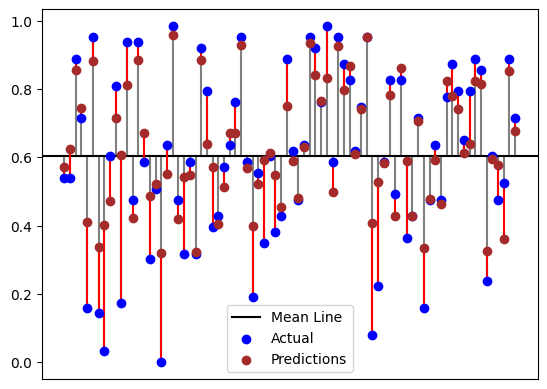

R2 Score: 74.2%
MAE Score: 0.089
MSE Score: 0.017


In [17]:
#implementing vanilla, stochastic and mini_batch descent methods without any regularization

#vanilla
LR_vanilla = LinearRegression(learning_rate = 0.01, iterations = 1000, gradient_descent_type = 'vanilla', regularization = 'None', lamda = 0)
LR_vanilla.fit(X_train, y_train)
y_pred = LR_vanilla.predict(X_test)
LR_vanilla_pipeline = Pipeline(y_pred, y_test)
LR_vanilla_pipeline.show()

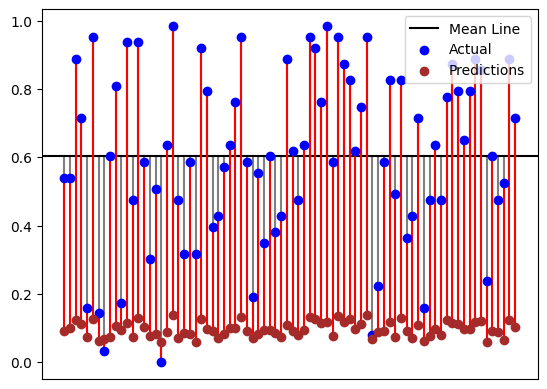

R2 Score: -381.8%
MAE Score: 0.51
MSE Score: 0.314


In [18]:
#stochastic
LR_stochastic = LinearRegression(learning_rate = 0.01, iterations = 1000, gradient_descent_type = 'stochastic', regularization = 'None', lamda = 0)
LR_stochastic.fit(X_train, y_train)
y_pred = LR_stochastic.predict(X_test)
LR_stochastic_pipeline = Pipeline(y_pred, y_test)
LR_stochastic_pipeline.show()

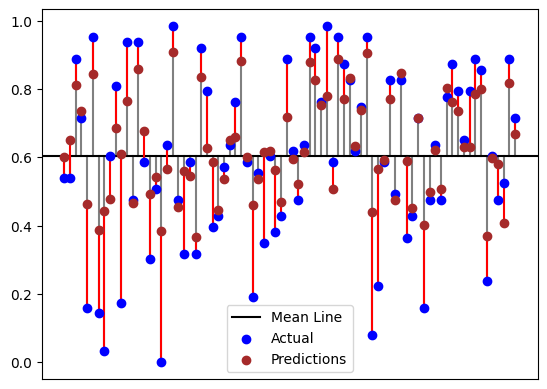

R2 Score: 66.8%
MAE Score: 0.104
MSE Score: 0.022


In [23]:
#mini_batch with batch_size = 32
LR_mini_batch = LinearRegression(learning_rate = 0.01, iterations = 1000, gradient_descent_type = 'mini_batch', regularization = 'None', lamda = 0)
LR_mini_batch.fit(X_train, y_train)
y_pred = LR_mini_batch.predict(X_test)
LR_mini_batch_pipeline = Pipeline(y_pred, y_test)
LR_mini_batch_pipeline.show()

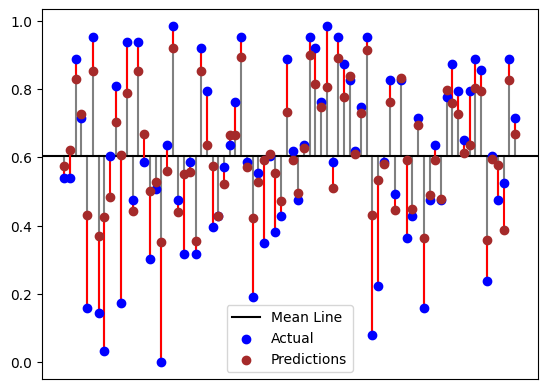

R2 Score: 70.7%
MAE Score: 0.098
MSE Score: 0.019


In [30]:
#implementing vanilla with L1 and L2 regularization

#L1 regularization
LR_vanilla_L1 = LinearRegression(learning_rate = 0.01, iterations = 1000, gradient_descent_type = 'vanilla', regularization = 'L1', lamda = 0.01)
LR_vanilla_L1.fit(X_train, y_train)
y_pred = LR_vanilla_L1.predict(X_test)
LR_vanilla_L1_pipeline = Pipeline(y_pred, y_test)
LR_vanilla_L1_pipeline.show()

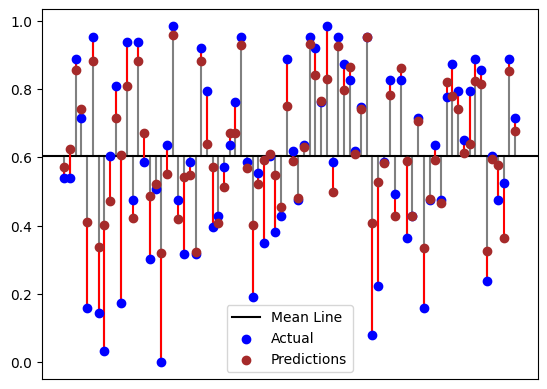

R2 Score: 74.1%
MAE Score: 0.089
MSE Score: 0.017


In [29]:
#L2 regularization
LR_vanilla_L2 = LinearRegression(learning_rate = 0.01, iterations = 1000, gradient_descent_type = 'vanilla', regularization = 'L2', lamda = 0.01)
LR_vanilla_L2.fit(X_train, y_train)
y_pred = LR_vanilla_L2.predict(X_test)
LR_vanilla_L2_pipeline = Pipeline(y_pred, y_test)
LR_vanilla_L2_pipeline.show()